In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# How do we know if a model is a good fit to a set of data?

A common interest across all sciences, and especially data science, is the idea of trying to fit a model to data, and evaluating how good that model is at explaining what we measure.

In order to help us understand some of the ideas involved, it's useful to generate some sample data where we know what we put in by hand from the outset, and see how well we can get it back.

Thinking back to our first notebook, imagine that each of our measurements was centered on the true value, with some standard deviation charactizing the size of our measurement errors:

Text(0, 0.5, 'Probability density')

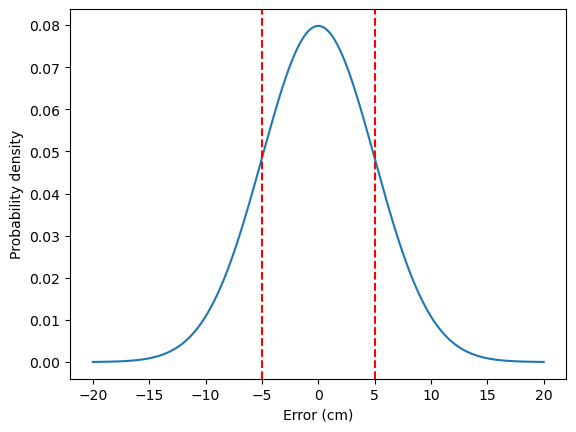

In [4]:
sigma=5 # cm
mu=0
derr = np.linspace(-20,20,1000)
pdf = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(derr-mu)**2/2/sigma**2) # equation for a gaussian

fig, ax = plt.subplots()
ax.plot(derr, pdf)
ax.axvline(sigma, c='r', linestyle='--')
ax.axvline(-sigma, c='r', linestyle='--')
ax.set_xlabel('Error (cm)')
ax.set_ylabel('Probability density')

Now let's imagine we have a (idealized!) spring we're stretching by different amounts, and we take measurements of the resulting acceleration when we let go. that the true model was 

$a=2x$

but our 10 a measurements have measurement errors of 5 $cm/s^2$. The *underlying* distribution of measurements would look like this, where each measurement is centered on the true value:

Text(0, 0.5, 'Acceleration (cm^2)')

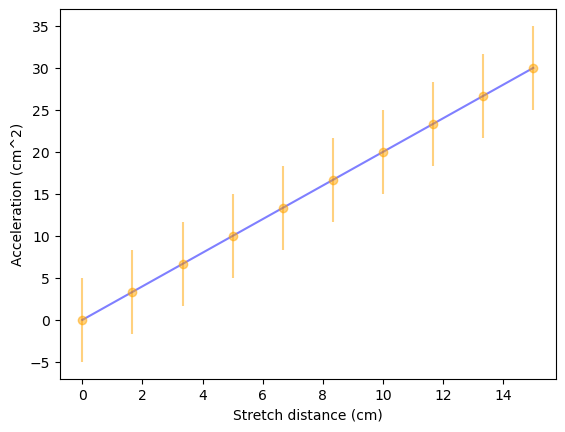

In [6]:
Npts = 10
yerr = 5
x = np.linspace(0, 15, Npts)
y = x*2
yunc = np.ones(Npts)*yerr

fig, ax = plt.subplots()
ax.errorbar(x, y, yunc, marker='o', color='blue', ecolor='orange', markerfacecolor='orange', markeredgecolor='orange', alpha=0.5)
ax.set_xlabel('Stretch distance (cm)')
ax.set_ylabel('Acceleration (cm^2)')

But what we measure for each point in reality is a random draw from that distribution, so a real dataset might look like this:

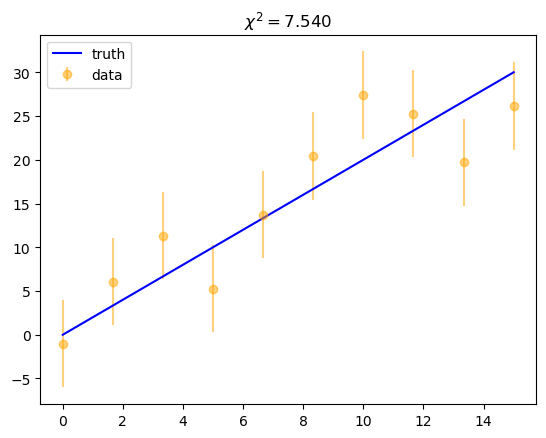

In [10]:
y_unc=5
y_true = 2*x
y = y_true + np.random.normal(scale=y_unc, size=Npts)
y_err = np.ones(Npts)*y_unc
chisq = np.sum(((y-y_true)/y_err)**2)

fig, ax = plt.subplots()
ax.errorbar(x, y, y_unc, marker='o', color='orange', linestyle='', alpha=0.5, label='data')
ax.plot(x, y_true, c='b', label='truth')
ax.set_title('$\chi^2 = {0:.3f}$'.format(chisq))
ax.legend()

In the data analysis guides we go through how we might quantify how good a fit like the blue line might be to this data. Along the top, we calculate the (total) $\chi^2$ for the true model (blue line).

The problem is that in practice we don't *know* what the right model is ahead of time, that's what we are trying to figure out. If we try to find the best-fit line to this data, we find a different slope and y-intercept from the true model we put in by hand. That's of course due to the random errors we have introduced:

In [11]:
m, b = np.polyfit(x, y, 1)
print("Slope = {0:.2f}, Y-intercept = {1:.2f}".format(m, b))

Slope = 1.76, Y-intercept = 2.26


Notice that the best fit line will have a lower $\chi^2$ than the true model! That's because the way the random measurements come down, there's probably a slightly different line that is better able to pass through the points (that's exactly why the fitter picked it!)

Text(0.5, 1.0, 'Slope = 1.78, Y-intercept = 0.81, $X^2$ = 6.40')

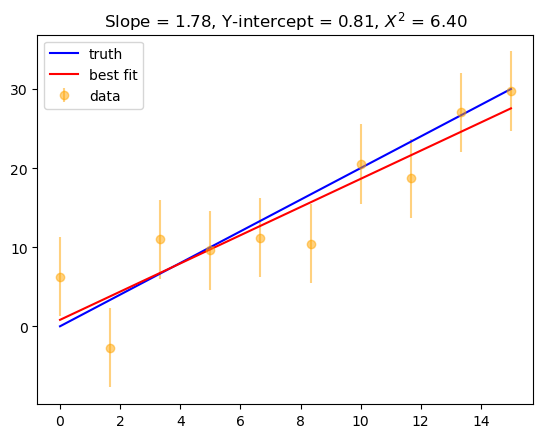

In [12]:
y_true = 2*x
y = y_true + np.random.normal(scale=y_unc, size=Npts)
y_err = np.ones(Npts)*y_unc
chisq = np.sum(((y-y_true)/y_err)**2)

fig, ax = plt.subplots()
ax.errorbar(x, y, y_unc, marker='o', color='orange', linestyle='', alpha=0.5, label='data')
ax.plot(x, y_true, c='b', label='truth')

m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x +b, c='r', label='best fit')
ax.legend()

ax.set_title("Slope = {0:.2f}, Y-intercept = {1:.2f}, $X^2$ = {2:.2f}".format(m, b, chisq))


# What is a good $\chi^2$?

That gets at the question of how good a value should we expect to find for $\chi^2$? Obviously a huge value is bad, since it means our model does not come close to the measurements, but a value of 0 (as we would get in the first line plot above) should also be worrying! If the error bars really are as large as we claim, then points should scatter around the true model by that amount.

There are good mathematical ways of getting at this question, but perhaps most intuitive is to do what we've done, i.e.

* assume a particular underlying model
* add random errors of a given size
* simulate a random dataset and calculate a $\chi^2$
* Do this many times, and empirically **see** what kinds of $\chi^2$ values the true model would obtain

The function below does exactly that. It takes a set of x values (our stretch distances), a set of what the true y values should be (accelerations), and a size for the measurement errors. It then simulates a dataset, and returns a $\chi^2$ for the correct model.

In [13]:
def realization(x, y_true, y_unc):
    y = y_true + np.random.normal(scale=y_unc, size=x.shape)
    y_err = np.ones(x.shape)*y_unc
    m, b = np.polyfit(x, y, 1)
    chisq = np.sum(((y-(m*x+b))/y_err)**2)
    return chisq

Each time we run it, we will get a different randomly generated experiment's $\chi^2$ (try it a few different times)

In [14]:
realization(x, y_true, y_unc)

5.284887819129106

Now let's run 100,000 such experiments and make a distribution of the results

In [15]:
%%time
Nchisqs=100000
chisqs = [realization(x, y_true, y_unc) for i in range(Nchisqs)]

CPU times: user 2.45 s, sys: 15.1 ms, total: 2.47 s
Wall time: 2.46 s


# Distribution of $X^2$

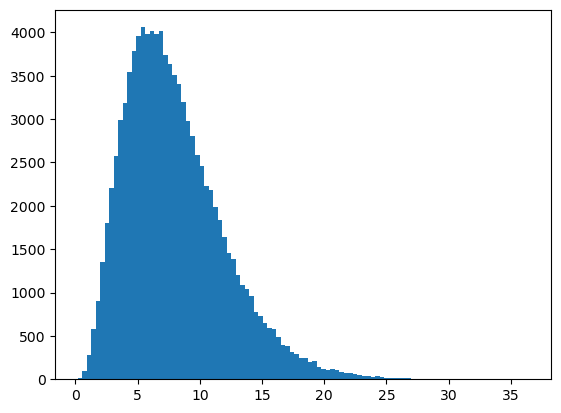

In [16]:
fig, ax = plt.subplots()
vals, bins, patches = ax.hist(chisqs, bins=100)

As discussed in the data analysis guides, a nice way to account for the number of measurements we're taking is to calculate a reduced $\chi^2$, which we see has a mode close to 1

# Reduced $X^2$

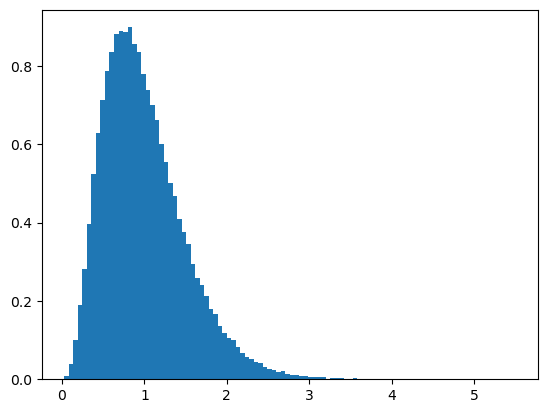

In [22]:
redchi2 = np.array(chisqs)/(Npts-2)
fig, ax = plt.subplots()
vals, bins, patches = ax.hist(redchi2, bins=100, density=True)

# A Well understood distribution

This sort of mental picture is a useful one, but like we mentioned before, this is something that can also be calculated using statistics. This distribution of $\chi^2$ values is a standard thing in statistics (creatively named a $\chi^2$ distribution). For example we can use scipy.stats to overplot what it should look like, and it matches nicely

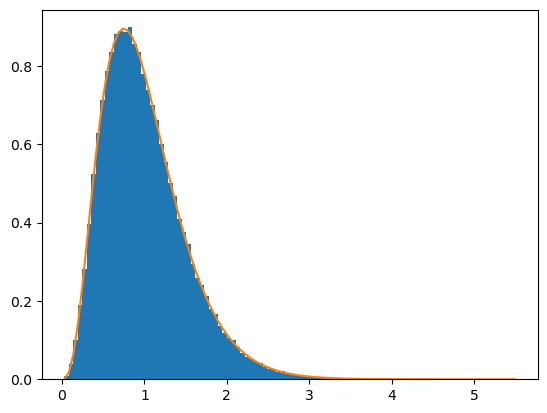

In [24]:
from scipy.stats import chi2
fig, ax = plt.subplots()
vals, bins, patches = ax.hist(redchi2, bins=100, density=True)
ax.plot(bins, (Npts-2)*chi2.pdf(bins*(Npts-2), df=(Npts-2)))

We can ask for example, what the median value is for $\chi^2$, such that half the time I run my experiment I would expect to be below it (just by chance) and half the time above it. In general this will be close to 1 for the reduced $\chi^2$, but for low numbers of degrees of freedom, it deviates slightly:

In [25]:
np.percentile(redchi2, 50)

0.9178896325301791